In [1]:
import torch

In [2]:
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image
import torchvision
import pathlib
import numpy as np
import cv2
import os
import random
import glob
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
transformer = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
train_path = r'G:\CSE_465\project\project\Dataset'
tests_path = r'G:\CSE_465\project\project\test'

train_dataloader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform = transformer),
    batch_size = 100,
    shuffle= True
)

test_dataloader = DataLoader(
    torchvision.datasets.ImageFolder(tests_path, transform = transformer),
    batch_size = 100,
    shuffle= True
)

In [6]:
classes = ['Bear','Camel','Cat','Dear','Dog','Elephant','Fish','Hamstar','Rakun','Tiger']

torch.Size([100, 3, 64, 64]) torch.Size([100])


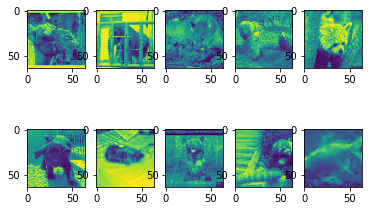

10


In [7]:
example = iter(train_dataloader)
samples, labels = example.next()
print(samples.shape, labels.shape)
for i in range(10):
    plt.subplot(2,5, i+1)
    plt.imshow(samples[i][0])
plt.show()
print(len(train_dataloader))

In [8]:
class FeedForward(torch.nn.Module):
    def __init__(self, input_size, hidden_size, numclasses):
        super(FeedForward, self).__init__()
        self.l1 = torch.nn.Linear(input_size, hidden_size)
        self.relu1 = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(hidden_size,50)
        self.relu2 = torch.nn.ReLU()
        self.l3 = torch.nn.Linear(50,numclasses)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu1(out)
        out = self.l2(out)
        out = self.relu2(out)
        out = self.l3(out)
        return out


In [9]:
model = FeedForward((3*64*64), 100, 10)
model = model.to(device)
epoch = 50

loss_arr = []

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_total_stapes = len(train_dataloader)
for  epochs in range(epoch):
    model.train()
    train_loss = 0.0
    train_accuricy = 0.0
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.reshape(-1, (3*64*64)).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().data*10
        
        _,prediction = torch.max(outputs.data,1)
        
        train_accuricy+= int(torch.sum(prediction==labels.data))
        
    train_accuricy = train_accuricy/1000
    train_loss = train_loss/1000
    loss_arr.append(train_loss)
    
    model.eval()
    test_accuricy= 0.0
    
    for i, (images, labels) in enumerate(test_dataloader):
        images = images.reshape(-1, (3*64*64)).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _,prediction = torch.max(outputs.data,1)
        
        test_accuricy+= int(torch.sum(prediction==labels.data))
        
    test_accuricy = test_accuricy/500
    print(f'Epoch {epochs+1} / {epoch} , Train Loss: {train_loss:.4f},  Train Accuricy:  {train_accuricy:.4f},   Test Accuricy:  {test_accuricy:.4f}' )   



Epoch 1 / 50 , Train Loss: 0.2357,  Train Accuricy:  0.1130,   Test Accuricy:  0.1120
Epoch 2 / 50 , Train Loss: 0.2281,  Train Accuricy:  0.1570,   Test Accuricy:  0.1720
Epoch 3 / 50 , Train Loss: 0.2200,  Train Accuricy:  0.2020,   Test Accuricy:  0.1660
Epoch 4 / 50 , Train Loss: 0.2146,  Train Accuricy:  0.2180,   Test Accuricy:  0.2440
Epoch 5 / 50 , Train Loss: 0.2055,  Train Accuricy:  0.2890,   Test Accuricy:  0.2440
Epoch 6 / 50 , Train Loss: 0.2029,  Train Accuricy:  0.2650,   Test Accuricy:  0.2780
Epoch 7 / 50 , Train Loss: 0.1955,  Train Accuricy:  0.3250,   Test Accuricy:  0.2560
Epoch 8 / 50 , Train Loss: 0.1910,  Train Accuricy:  0.3450,   Test Accuricy:  0.2380
Epoch 9 / 50 , Train Loss: 0.1880,  Train Accuricy:  0.3560,   Test Accuricy:  0.2300
Epoch 10 / 50 , Train Loss: 0.1869,  Train Accuricy:  0.3450,   Test Accuricy:  0.2740
Epoch 11 / 50 , Train Loss: 0.1807,  Train Accuricy:  0.3730,   Test Accuricy:  0.2360
Epoch 12 / 50 , Train Loss: 0.1737,  Train Accuricy:

In [10]:
class CNN(torch.nn.Module):
    def __init__(self, numclasses):
        super(CNN, self).__init__()
        
        self.con1 = torch.nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=3, stride= 1)
        
        self.con2 = torch.nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.relu2 = torch.nn.ReLU() 
        self.pool2 = torch.nn.MaxPool2d(kernel_size=3, stride= 1)
        
        self.con3 = torch.nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=3, stride= 1)
        
        self.l1 = torch.nn.Linear((32*58*58), 50)
        self.relu4 = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(50,numclasses)
        
    def forward(self, x):
        out = self.con1(x)
        out = self.relu1(out)
        out = self.pool1(out)
#         print(out.shape)
        out = self.con2(out)
        out = self.relu2(out)
        out = self.pool2(out)
#         print(out.shape)
        out = self.con3(out)
        out = self.relu3(out)
        out = self.pool3(out)
        
#         print(out.shape)
        out = out.view(-1, 32*58*58)
        
        out = self.l1(out)
        out = self.relu4(out)
        out = self.l2(out)
        
        return out
        

In [ ]:
modelCNN = CNN(10)
modelCNN = modelCNN.to(device)
epoch = 50

loss_arr_CNN = []

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=0.001)

n_total_stapes = len(train_dataloader)
for  epochs in range(epoch):
    modelCNN.train()
    train_loss = 0.0
    train_accuricy = 0.0
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = modelCNN(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().data*10
        
        _,prediction = torch.max(outputs.data,1)
        
        train_accuricy+= int(torch.sum(prediction==labels.data))
        
    train_accuricy = train_accuricy/1000
    train_loss = train_loss/1000
    loss_arr_CNN.append(train_loss)
    
    modelCNN.eval()
    test_accuricy= 0.0
    
    for i, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = modelCNN(images)
        _,prediction = torch.max(outputs.data,1)
        
        test_accuricy+= int(torch.sum(prediction==labels.data))
        
    test_accuricy = test_accuricy/500
    print(f'Epoch {epochs+1} / {epoch} , Train Loss: {train_loss:.4f},  Train Accuricy:  {train_accuricy:.4f},   Test Accuricy:  {test_accuricy:.4f}' )   



Epoch 1 / 50 , Train Loss: 0.2381,  Train Accuricy:  0.0970,   Test Accuricy:  0.1260
Epoch 2 / 50 , Train Loss: 0.2253,  Train Accuricy:  0.1830,   Test Accuricy:  0.2360
Epoch 3 / 50 , Train Loss: 0.2070,  Train Accuricy:  0.2260,   Test Accuricy:  0.2760
Epoch 4 / 50 , Train Loss: 0.1889,  Train Accuricy:  0.3340,   Test Accuricy:  0.2980
Epoch 5 / 50 , Train Loss: 0.1723,  Train Accuricy:  0.3750,   Test Accuricy:  0.3300
Epoch 6 / 50 , Train Loss: 0.1584,  Train Accuricy:  0.4390,   Test Accuricy:  0.3440
Epoch 7 / 50 , Train Loss: 0.1365,  Train Accuricy:  0.5430,   Test Accuricy:  0.3560
Epoch 8 / 50 , Train Loss: 0.1215,  Train Accuricy:  0.5890,   Test Accuricy:  0.3460
Epoch 9 / 50 , Train Loss: 0.1069,  Train Accuricy:  0.6460,   Test Accuricy:  0.3400
Epoch 10 / 50 , Train Loss: 0.0915,  Train Accuricy:  0.6960,   Test Accuricy:  0.3260
Epoch 11 / 50 , Train Loss: 0.0753,  Train Accuricy:  0.7600,   Test Accuricy:  0.3380
Epoch 12 / 50 , Train Loss: 0.0569,  Train Accuricy:

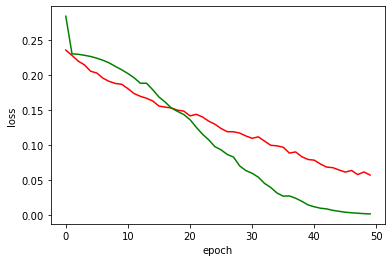

In [12]:
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.plot(np.array(loss_arr), 'red')
plt.plot(np.array(loss_arr_CNN), 'green')

In [13]:
def Prediction(image_path , transformer):
    image = Image.open(image_path)
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.reshape(-1,(3*64*64))
    image_tensor = image_tensor.unsqueeze_(0)
    image_tensor.to(device)
       
        
    input = Variable(image_tensor).to(device)

    output = model(input)
    output = output.cpu()
    index = output.data.numpy().argmax()
    
    pred = classes[index]
    
    return pred


In [14]:
def PredictionCNN(image_path , transformer):
    image = Image.open(image_path)
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    image_tensor.to(device)
       
        
    input = Variable(image_tensor).to(device)

    output = modelCNN(input)
    output = output.cpu()
    index = output.data.numpy().argmax()
    
    pred = classes[index]
    
    return pred


In [15]:
PredictionCNN("G:/CSE_465/project/project/n02437312_129.JPEG", transformer)

'Elephant'

In [16]:
Prediction("G:/CSE_465/project/project/n02437312_129.JPEG", transformer)

'Dear'